In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_palette("GnBu_d")
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
%matplotlib inline

In [2]:
brm_hourly_driven = pd.read_csv("../generated/brm_hourly_driven.csv")
frb_hourly_driven = pd.read_csv("../generated/frb_hourly_driven.csv")

brm_hourly_weather = pd.read_csv("../generated/brm_hourly_weather.csv")
frb_hourly_weather = pd.read_csv("../generated/frb_hourly_weather.csv")

## Prediction

In [3]:
def merge_duration_and_weather(duration, weather):
    return duration.merge(how="left", left_on=["day", "hour"], right_on=["day","hour"], right=weather)

def timedelta_to_hours(timedelta_array):
    return timedelta_array.map(lambda x: x / pd.Timedelta("1 hour"))

def add_weekday(frame):
    frame["day"] = pd.to_datetime(frame["day"])
    frame["weekday"] = frame["day"].map(lambda x: x.weekday())
    return frame
    
def split_weekday(frame):
    frame = add_weekday(frame)
    weekdays = [None]*7
    for i in range(0,6):
        weekdays[i] = frame[frame["weekday"]==i]
    return weekdays

def regression(frame,frame_model):
    y = frame["trip_duration"]
    X = frame[["temperature","precipitation"]]
    frame_model.fit(X, y)
    predict = frame_model.predict(X)
    return predict

def plot_regression(X,y, predict):
    plt.figure(figsize = (8,6))
    plt.scatter(X, y, marker="x")
    plt.xlabel("temperature in °C")
    plt.ylabel("trip duration in h")
    plt.plot(X, predict, c='C2')
    plt.legend(['Squared loss fit','Observed hours'])


def split(X, y, train_size, validate_size):
    if (train_size+validate_size) <= 1:
        x_train, x_tmp, y_train, y_tmp = train_test_split(X, y, test_size=(1-train_size))
        x_validate, x_test, y_validate, y_test = train_test_split(x_tmp, y_tmp, test_size=(1-validate_size/(1-train_size)))
        return x_train, x_validate, x_test, y_train, y_validate, y_test

regression models:

In [4]:
def linear_regression(X, y):

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    model = LinearRegression()
    model.fit(x_train, y_train)
    print("Coefficients ", model.coef_, "\nIntercept ", model.intercept_ )
    predict = model.predict(x_test)
    print("MSE: ", mean_squared_error(y_test, predict))
    print ("R^2: " ,r2_score(y_test, predict))


def polynomial_regression(X, y, degree):

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    model = LinearRegression()
    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(x_train)
    x_poly_test = poly_features.fit_transform(x_test)
    model.fit(x_poly, y_train)

    print("Coefficients ", model.coef_, "\nIntercept ", model.intercept_ )
    predict = model.predict(x_poly_test)
    print("MSE:", mean_squared_error(y_test, predict))
    print ("R^2: " ,r2_score(y_test, predict))


def ridge_regression(X, y, degree, alpha):

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(x_train)
    x_poly_test = poly_features.fit_transform(x_test)

    model = Ridge(alpha, normalize=True)
    model.fit(x_poly, y_train)
    print("Coefficients ", model.coef_, "\nIntercept ", model.intercept_ )
    predict = model.predict(x_poly_test)
    print("MSE:", mean_squared_error(y_test, predict))



def lasso_regression(X, y, degree, alpha):
    x_train, x_validate, x_test, y_train, y_validate, y_test = split(X, y, train_size=0.6, validate_size=0.2)

    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(x_train)
    x_poly_validate = poly_features.fit_transform(x_validate)

    model = Lasso(alpha)
    model.fit(x_poly, y_train)

    print("Coefficients ", model.coef_, "\nIntercept ", model.intercept_ )
    predict = model.predict(x_poly_validate)
    print("MSE:", mean_squared_error(y_validate, predict))

In [5]:
frb_hourly = merge_duration_and_weather(frb_hourly_driven, frb_hourly_weather)
frb_hourly["trip_duration"] = timedelta_to_hours(frb_hourly["trip_duration"])

brm_hourly = merge_duration_and_weather(brm_hourly_driven, brm_hourly_weather)
brm_hourly["trip_duration"] = timedelta_to_hours(brm_hourly["trip_duration"])

frb_weekdays = split_weekday(frb_hourly)
brm_weekdays = split_weekday(brm_hourly)

In [6]:
trip_duration = frb_weekdays[0]["trip_duration"]
f1 = frb_weekdays[0]["temperature"]
f2 = frb_weekdays[0]["precipitation"]
f3 = frb_weekdays[0]["hour"]

Example plot for mondays

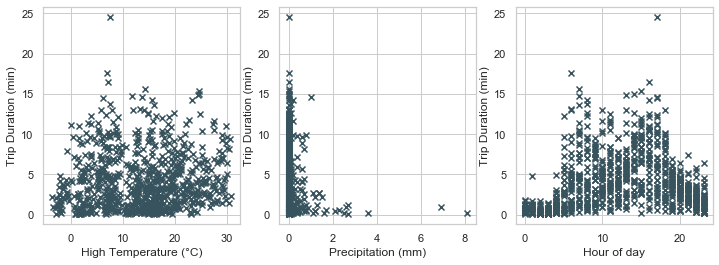

In [7]:
fig = plt.figure(figsize = (12,4))
ax = fig.add_subplot(1,3,1)
ax.scatter(f1,trip_duration, marker='x')
ax.set_xlabel("High Temperature (°C)")
ax.set_ylabel("Trip Duration (min)")
bx =  fig.add_subplot(1,3,2)
bx.scatter(f2,trip_duration, marker='x')
bx.set_xlabel("Precipitation (mm)")
bx.set_ylabel("Trip Duration (min)")
cx =  fig.add_subplot(1,3,3)
cx.scatter(f3,trip_duration, marker='x')
cx.set_xlabel("Hour of day")
cx.set_ylabel("Trip Duration (min)")
plt.show()

In [8]:
#Split

features = frb_hourly[["precipitation", "temperature", "hour"]]
predictor = frb_hourly["trip_duration"]

###  Linear regression

In [9]:
linear_regression(features, predictor)

Coefficients  [-0.39871566  0.02753691  0.09735902] 
Intercept  2.347685335225631
MSE:  9.24244468453966
R^2:  0.05543913129541289


### Polynomial regression

In [10]:
polynomial_regression(features, predictor, 3)

Coefficients  [ 0.00000000e+00 -2.02643004e-01  1.02967686e-01 -1.04471696e-01
  6.63125965e-01 -2.04866664e-01 -2.44626437e-01 -1.21555643e-02
  2.00612308e-02  5.90678443e-02 -2.01772065e-02 -1.48361109e-02
  2.23682894e-03  9.73015261e-03 -2.81960885e-04  8.69933657e-03
  1.26487197e-04  1.69817281e-04 -1.00763672e-03 -2.32388325e-03] 
Intercept  1.560071484098697
MSE: 10.871226960606311
R^2:  -0.08282327439047399


### Ridge regression

In [11]:
ridge_regression(features, predictor, 3, 0.01)

Coefficients  [ 0.00000000e+00 -6.95144339e-01  2.99506015e-02  4.33141087e-01
  4.86332274e-02 -4.18936698e-04 -5.55158057e-02 -4.18568213e-03
  8.49317898e-03  3.54856037e-03 -2.04926218e-03  9.32187224e-04
  3.22989787e-03  8.76950352e-04 -2.39424720e-03  2.11453625e-03
  2.09478401e-05  8.44063867e-05 -4.33325332e-04 -8.30559671e-04] 
Intercept  0.8866823452638184
MSE: 7.293721323349736


### Lasso regression

In [12]:
ridge_regression(features, predictor, 3, 0.01)

Coefficients  [ 0.00000000e+00 -6.57026887e-01  3.10140152e-02  4.16687368e-01
  3.73077441e-02  2.24319665e-03 -5.99052750e-02 -4.07962802e-03
  8.98888273e-03  3.93399412e-03 -1.82499150e-03  8.75217383e-04
  3.64898833e-03  1.07869899e-03 -2.81759386e-03  2.31659179e-03
  5.92516125e-06  1.17915952e-04 -4.58394003e-04 -8.31933644e-04] 
Intercept  0.9007819226504692
MSE: 7.567212590093057


Split the data set into traing(60%), validation(20%), test(20%) setst to prevent leakage.

In [13]:
x_train, x_validate, x_test = np.split(brm_weekdays[0]['temperature'].sample(frac=1), [int(.6*len(brm_weekdays[0]['temperature'])), int(.8*len(brm_weekdays[0]['temperature']))])
y_train, y_validate, y_test = np.split(brm_weekdays[0]['trip_duration'].sample(frac=1), [int(.6*len(brm_weekdays[0]['trip_duration'])), int(.8*len(brm_weekdays[0]['trip_duration']))])

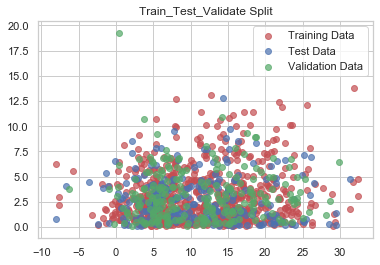

In [14]:
plt.scatter(x_train, y_train, label = "Training Data", color = "r", alpha =.7)
plt.scatter(x_test, y_test, label = "Test Data", color = "b", alpha =.7)
plt.scatter(x_validate, y_validate, label = "Validation Data", color = "g", alpha =.7)
plt.legend()
plt.title("Train_Test_Validate Split")
plt.show()

In [15]:
#Create linear model and train it 
lr = LinearRegression()
lr.fit(x_train.values.reshape(-1, 1), y_train.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

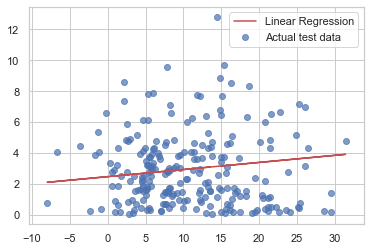

In [16]:
# Use model to predict on test data
prediction = lr.predict(x_test.values.reshape(-1, 1))

# Plot prediction line against actual test data 
plt.plot(x_test, prediction, label='Linear Regression', color = 'r')
plt.scatter(x_test, y_test, label='Actual test data', color = 'b', alpha=.7)
plt.legend()
plt.show()

The best score that we could achieve for a model is 1.0. 
~Soo our linear model is not that great...

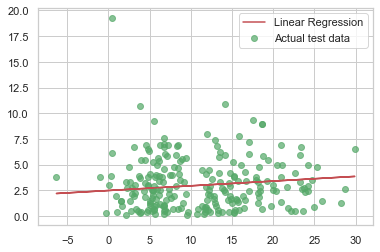

In [17]:
# Plot prediction line against actual test data 
prediction = lr.predict(x_validate.values.reshape(-1, 1))
plt.plot(x_validate, prediction, label='Linear Regression', color = 'r')
plt.scatter(x_validate, y_validate, label='Actual test data', color = 'g', alpha=.7)
plt.legend()
plt.show()

In [18]:
# Score the model 
lr.score(x_validate.values.reshape(-1, 1), y_validate.values)

-0.01770511646979145

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [20]:
y_true = y_validate
y_pred = lr.predict(x_validate.values.reshape((-1,1)))

In [21]:
print("Mean Squared Error:",mean_squared_error(y_pred, y_true))
print("Root Mean Squared Error:",mean_squared_error(y_pred, y_true)**0.5)
print("Coefficient of determination:",r2_score(y_pred, y_true))

Mean Squared Error: 6.401612849355543
Root Mean Squared Error: 2.530140875397167
Coefficient of determination: -62.459241666301615


### Polynomial  regression

In [22]:
from sklearn.preprocessing import PolynomialFeatures


In [23]:
def plot_regression_poly(X,Y,d):
    
    # initialize PolynomialFeatures
    poly_reg = PolynomialFeatures (degree = d)
    
    # Polynomial transformation
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    lin_reg_Poly = LinearRegression()
    
    # Fitting linear regression to polynomial features
    lin_reg_Poly.fit(x_poly, Y)
    model_pred = lin_reg_Poly.predict(x_poly)
    
    # Plotting the regression line and the data (we have to transform the inputs as well!)
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.figure(figsize = (8,6))
    plt.scatter(X,Y,marker="o", c='C2')
    ylim = plt.ylim()
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (Min)")
    plt.xlim([X.min()-2,X.max()+2]) # leave some space before and after limits
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    print(lin_reg_Poly.coef_) 

The R^2 for quadratic curve is:  0.018355846637821416
[ 0.00000000e+00 -9.71880566e-03  1.14790733e-02 -7.04720627e-04
  1.31527185e-05]


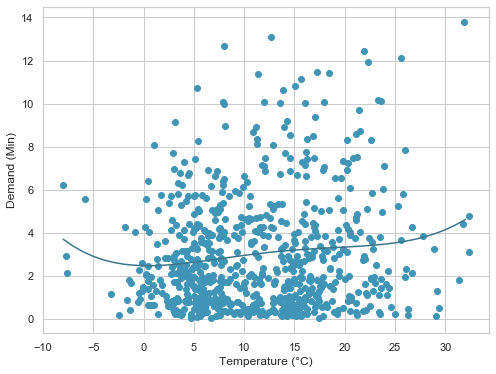

In [24]:
xp = x_train.values

yp = y_train 

plot_regression_poly(X = xp, Y = yp, d = 4)

The R^2 for quadratic curve is:  0.004976155221024792
[ 0.00000000e+00  3.40029690e-02  4.27080177e-03 -5.04882737e-04
  1.06425912e-05]


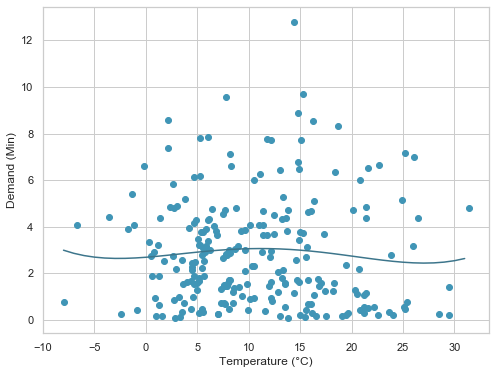

In [25]:
xp = x_test.values

yp = y_test 

plot_regression_poly(X = xp, Y = yp, d = 4)

The R^2 for quadratic curve is:  0.004827213565178123
[ 0.00000000e+00 -1.24268785e-01  6.89223836e-03  2.87050443e-05
 -4.61043414e-06]


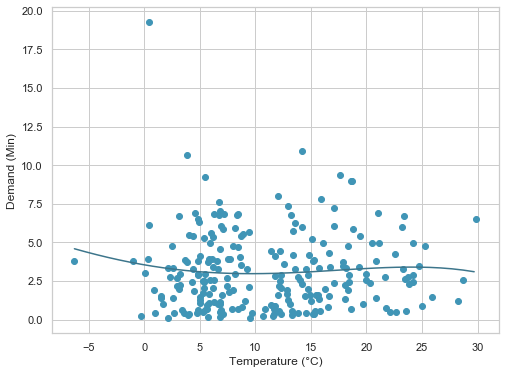

In [26]:
xp = x_validate.values

yp = y_validate 

plot_regression_poly(X = xp, Y = yp, d = 4)

In [27]:
plot_regression_poly

<function __main__.plot_regression_poly(X, Y, d)>

### Idea

Split dataset into train_test_validate sets not for every hour individually but rather hourly.